yt : [INFO     ] 2024-05-13 14:33:45,117 Parameters: current_time              = 946096478896639.9
yt : [INFO     ] 2024-05-13 14:33:45,118 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2024-05-13 14:33:45,119 Parameters: domain_left_edge          = [-7.715e+20 -7.715e+20 -7.715e+20]
yt : [INFO     ] 2024-05-13 14:33:45,120 Parameters: domain_right_edge         = [7.715e+20 7.715e+20 7.715e+20]
yt : [INFO     ] 2024-05-13 14:33:45,121 Parameters: cosmological_simulation   = 0


loop over cells:  116


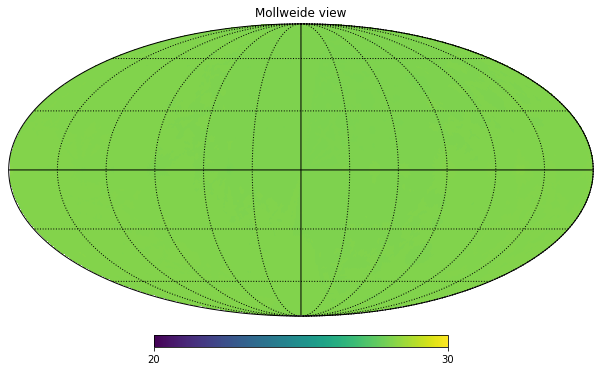

In [12]:
import numpy as np
import healpy as hp
import h5py
import matplotlib.pyplot as plt
import yt

nside = 64

min=20.
max=30.

pc = 3.085678e+18
kpc = 1e3 * pc

cx = -80.
cy = -150.
cz = 0.0

c = ([cx, cy, cz], "pc")          # new yt version
c = [-80.0*pc, -150.0*pc, 0.0*pc] # old yt version

Rmax_pc = 50.

for files in ["SILCC_hdf5_plt_cnt_3000"]:
    
    ds = yt.load(files)
    
    sp = ds.sphere(c, (Rmax_pc, "pc"))
    
    posx_ctr = sp[("gas", "x")].in_units("pc").v - cx
    posy_ctr = sp[("gas", "y")].in_units("pc").v - cy
    posz_ctr = sp[("gas", "z")].in_units("pc").v - cz
    
    # radius based on centre of mass
    rad_ctr = np.sqrt(posx_ctr**2 + posy_ctr**2 + posz_ctr**2)
    
    # and normalise it
    vec_norm_x = posx_ctr / rad_ctr   
    vec_norm_y = posy_ctr / rad_ctr   
    vec_norm_z = posz_ctr / rad_ctr   
        
    # compute angular size of all cells at the respective distance to the observer
    R = (3 * sp[("gas", "cell_volume")].v / (4 * np.pi))**(1./3.)
    angle = np.arctan2(R, rad_ctr)
    
    # set up healpix map
    NPIX = hp.nside2npix(nside)
    im_loc = np.zeros(NPIX)
        
    # and total mass in map
    Mtot_loc = 0.0
    
    Ncell = rad_ctr.size
    # loop over cells and fill HP map
    print("loop over cells: ", Ncell)
    for i in range(Ncell):
        Mtot_loc = Mtot_loc + sp[("gas","cell_mass")][i].v
        pixels = hp.query_disc(nside, [vec_norm_x[i], vec_norm_y[i], vec_norm_z[i]], angle[i], inclusive=True,)  
        for p in pixels:
            im_loc[p] += sp[("gas","cell_mass")][i].v/len(pixels)

    min = np.min(im_loc)
    max = np.max(im_loc)
    hp.mollview(np.log10(im_loc), return_projected_map=True, min=min, max=max)
    hp.graticule()
    plt.savefig(files+"-mollweide-coldens.pdf", bbox_inches="tight")
    plt.savefig(files+"-mollweide-coldens.png", bbox_inches="tight", dpi=300)

